# Applying the Expected Context Framework to Wikipedia discussions

This notebook demonstrates an application of the Expected Context Framework to analyze Wikipedia talk page discussions. We are working up to the following question: what types of comments are more likely to start conversations that eventually derail into toxic personal attacks, versus conversations that remain civil throughout? The notebook goes over a few key function calls along the way. See [this paper](https://www.cs.cornell.edu/~cristian/Conversations_gone_awry_files/conversations_gone_awry.pdf) for details on the analysis question and datasets, and [this dissertation](https://tisjune.github.io/research/dissertation) for details on the framework and more comments on the below analyses.

For this demo, we start by training an Expected Context Model on a collection of Wikipedia discussions (different from the dataset we later analyze). In short, we want to infer different _rhetorical types_ of comments that occur at the start of these discussions. Via the framework, we'll derive representations of comments based on their expected replies (the "forwards context" of the conversation), and then infer types of comments by clustering these representations. We interpret the resultant clusters as different rhetorical types.

For an extended version of this analysis, on a slightly older implementation of the model (using the `PromptTypes` functionality), see [this notebook](https://github.com/CornellNLP/ConvoKit/blob/master/examples/conversations-gone-awry/Conversations_Gone_Awry_Prediction.ipynb).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import math
import os

## 1. Loading and preprocessing the training data

In [4]:
from convokit import Corpus
from convokit import download

In [5]:
# OPTION 1: DOWNLOAD CORPUS 
# UNCOMMENT THESE LINES TO DOWNLOAD CORPUS
# DATA_DIR = '<YOUR DIRECTORY>'
# WIKI_CORPUS_PATH = download('wiki-corpus', data_dir=DATA_DIR)

# OPTION 2: READ PREVIOUSLY-DOWNLOADED CORPUS FROM DISK
# UNCOMMENT THIS LINE AND REPLACE WITH THE DIRECTORY WHERE THE TENNIS-CORPUS IS LOCATED
# WIKI_CORPUS_PATH = '<YOUR DIRECTORY>'

In [7]:
wiki_corpus = Corpus(WIKI_CORPUS_PATH)

In [8]:
wiki_corpus.print_summary_stats()

Number of Speakers: 38462
Number of Utterances: 391294
Number of Conversations: 125292


We represent Wikipedia comments as dependency-parse arcs; in order to capture  rhetorical rather than topical information, we've removed nouns. These features are included with the release of the corpus, and can be loaded as follows:

In [9]:
wiki_corpus.load_info('utterance',['arcs_censored'])

To make sure that the arcs are stored in the right format (i.e., as strings, not lists), we apply the following transformer:

In [10]:
from convokit.text_processing import TextProcessor
join_arcs = TextProcessor(input_field='arcs_censored', output_field='arcs',
                     proc_fn=lambda sents: '\n'.join(sents))
wiki_corpus = join_arcs.transform(wiki_corpus)

In applying the framework, we need to associate utterances with their replies. One comment can receive multiple replies; here, we arbitrarily choose one (noting that future work could make better use of this additional information). 

In [11]:
for ut in wiki_corpus.iter_utterances(selector=lambda x: x.reply_to is not None):
    wiki_corpus.get_utterance(ut.reply_to).meta['next_id'] = ut.id

## 2. Applying the Expected Context Framework


In [12]:
from convokit.expected_context_framework import ColNormedTfidfTransformer, ExpectedContextModelTransformer

To apply the Expected Context Framework, we start by converting the input utterance text to an input vector representation. Here, we represent utterances in a term-document matrix that's _normalized by columns_ (empirically, we found that this ensures that the representations derived by the framework aren't skewed by the relative frequency of utterances). We use the `ColNormedTfidfTransformer` transformer to do this.

We found that it was preferable to derive different tf-idf representations (and hence different inverse document frequencies, normalization terms, and vocabularies) for comments that receive replies, and utterances that have predecessors. We make this partitioning by passing in different selectors to the `fit` functions below.

The two sets are of course overlapping, but the former set mostly contains comments that start conversations, and the second contains more comments that reply to conversation-starters. We note that we'd expect the language of conversation-starters and repliers to be slightly different (i.e., the former tend to be requests, and the latter tend to be responses to these requests).

In [13]:
first_tfidf_obj = ColNormedTfidfTransformer(input_field='arcs', output_field='first_tfidf', binary=True, min_df=50)
_ = first_tfidf_obj.fit(wiki_corpus, selector=lambda x: x.meta.get('next_id',None) is not None)
_ = first_tfidf_obj.transform(wiki_corpus)

second_tfidf_obj = ColNormedTfidfTransformer(input_field='arcs', output_field='second_tfidf', binary=True, min_df=50)
_ = second_tfidf_obj.fit(wiki_corpus, selector=lambda x: x.reply_to is not None)
_ = second_tfidf_obj.transform(wiki_corpus)

We then initialize an Expected Context Model:
* we specify that the conversational context we will derive our comment representations from is the reply, `context_field=next_id`
* as input, the model will use tf-idf representations from `vect_field=first_tfidf` to represent comments, and `context_vect_field=second_tfidf` to represent context comments
* we'll derive `n_svd_dims=25`-dimensional representations, and infer `n_clusters=6` clusters
* to infer these clusters, we will cluster _term_-level representations, `cluster_on='terms'`. Note that by default, the model will cluster _comment_-level representations, but in this context (perhaps since comments can get fairly long and unstructured), clustering on terms produces more interpretable output.

In [14]:
ec_fw = ExpectedContextModelTransformer(
    context_field='next_id', output_prefix='fw', 
    vect_field='first_tfidf', context_vect_field='second_tfidf', 
      n_svd_dims=25, n_clusters=6, cluster_on='terms',
     random_state=1000, cluster_random_state=1000)

(note that the following call takes some time to run)

In [15]:
ec_fw.fit(wiki_corpus, selector=lambda x: (x.meta.get('first_tfidf__n_feats',0)>=1)
                                  and (x.meta.get('next_id',None) is not None), 
            context_selector=lambda x: (x.meta.get('second_tfidf__n_feats',0)>= 1)
                         and (x.reply_to is not None))

### Inferred comment types

Below, we print representative terms, comments, and context terms and comments for the clusters we've inferred (note that the output is quite long)

In [16]:
ec_fw.print_clusters(k=10,corpus=wiki_corpus,max_chars=200)

CLUSTER 0 0
---
terms
           cluster_dist
index                  
'm_*           0.497348
thought_*      0.498929
guess_*        0.508338
sorry>*        0.521577
know_*         0.526687
had_*          0.531728
got_*          0.537593
's_*           0.543810
have>*         0.544413
saw_*          0.549280

context terms
          cluster_dist
index                 
saw_*         0.598228
yes>*         0.603147
knew_*        0.607990
but>*         0.614208
oh>*          0.615937
anyway>*      0.619059
hey>*         0.620055
guess_*       0.620307
oh_*          0.635252
and>*         0.639936


utterances
> 512605 0.456 Thanks for your help but I thought I'd point [http:\/\/en.wikipedia.org\/w\/index.php?title=List_of_Playboy_Playmates_of_1962&curid=27082401&diff=358137637&oldid=357917384 this] out.  Thanks again, <s
> 384706 0.463 Sorry but I don't know. I 've seen people doing this manually based. -- 
> 58226 0.464 Hi WFinch. I think it's awesome that you're improving Nero Wolfe art

> 116734 0.471 also ... you deleted mention in the body of at least one bio of the fact that the person was Jewish.  Please RV all such deletions, or let me know why you do not wish to do so.  Thanks. --
> 111384 0.473 To clarify, [[WP:G4]] only applies to articles deleted per a [[WP:XFD|deletion discussion]], not those deleted via [[WP:CSD]]. Cheers \u2014
> 373927 0.474 the article was deleted due to copyright infringement. OTRS has received permission from the copyright holder under CC-by-sa-3.0 to use the material. If you have OTRS access, please consult ticket# 20
> 23238 0.475 I know you've managed to deflect concerns about your userpage in the past, Timeshift, but I'm afraid it'll be best for everyone if you take GorillaWarfare's advice now, rather than taking this to an M
> 490974 0.476 Hi. Please do not recreate \"WP:USER.pce3@ij.net\". Doing so constitutes recreation of deleted material and will be deleted on sight and may lead to blocking of your account. --PS2pcGAMER (talk)

demo continues below

Per our interpretation, we assign the following names to these clusters:

In [17]:
ec_fw.set_cluster_names(['casual', 'coordination', 
              'procedures', 'contention',
             'editing', 'moderation'])

In [18]:
ec_fw.print_cluster_stats()

,utts,terms,context_utts,context_terms
casual,0.336966,0.195341,0.201834,0.205236
contention,0.097679,0.174233,0.202557,0.237722
coordination,0.348370,0.199721,0.136531,0.105293
editing,0.019979,0.160892,0.225581,0.202943
moderation,0.097966,0.153724,0.118555,0.130136
procedures,0.099040,0.116089,0.114942,0.118670


## 2. Application to analysis data

We now use the comment types we've just derived to analyze a dataset containing conversations that eventually derail into toxic behavior, and conversations that stay on track throughout. We load this data:

In [19]:
# OPTION 1: DOWNLOAD CORPUS 
# UNCOMMENT THESE LINES TO DOWNLOAD CORPUS
# DATA_DIR = '<YOUR DIRECTORY>'
# AWRY_CORPUS_PATH = download('conversations-gone-awry-corpus', data_dir=DATA_DIR)

# OPTION 2: READ PREVIOUSLY-DOWNLOADED CORPUS FROM DISK
# UNCOMMENT THIS LINE AND REPLACE WITH THE DIRECTORY WHERE THE TENNIS-CORPUS IS LOCATED
# AWRY_CORPUS_PATH = '<YOUR DIRECTORY>'

In [20]:
awry_corpus = Corpus(AWRY_CORPUS_PATH)

In [21]:
awry_corpus = awry_corpus.filter_conversations_by(lambda convo: convo.meta['annotation_year'] == '2018')
# here we filter to consider only the conversations from the original paper

In [22]:
awry_corpus.print_summary_stats()

Number of Speakers: 2010
Number of Utterances: 6363
Number of Conversations: 1168


We start by extracting the same noun-less dependency parse arcs that we used when training the model, above. To do this, we need to load the dependency parses, and then apply a few additional transformers, below:

In [23]:
awry_corpus.load_info('utterance',['parsed'])

In [24]:
from demo_text_pipelines import wiki_arc_pipeline
# see `demo_text_pipelines.py` in this demo's directory for details
# in short, this pipeline will compute the dependency-parse arcs we use as input features,
# but will skip over utterances for which these attributes already exist
awry_corpus = wiki_arc_pipeline().transform(awry_corpus)

We represent the comments from the new dataset as tf-idf vectors, using the vocabulary and parameters we've derived over the training data:

In [25]:
awry_corpus = first_tfidf_obj.transform(awry_corpus)
awry_corpus = second_tfidf_obj.transform(awry_corpus)

Finally, we apply the trained model to transform the new dataset. In particular, we annotate each comment with an attribute, `fw_clustering.cluster`, that denotes the comment type it's assigned to:

In [26]:
awry_corpus = ec_fw.transform(awry_corpus)

To facilitate subsequent analyses, we will gather the comment types for each comment into a table:

In [27]:
cluster_assign_df = awry_corpus.get_attribute_table('utterance',['fw_clustering.cluster_id_'])
type_assignments = np.zeros((len(cluster_assign_df), 6))
type_assignments[np.arange(len(cluster_assign_df)),cluster_assign_df['fw_clustering.cluster_id_'].values.astype(int)] = 1
cluster_assign_df = pd.DataFrame(columns=np.arange(6), index=cluster_assign_df.index, data=type_assignments)
cluster_assign_df.columns = ec_fw.get_cluster_names()

In [28]:
cluster_assign_df.head()

,casual,coordination,procedures,contention,editing,moderation
id,,,,,,
146743638.12652.12652,0.0,0.0,0.0,0.0,1.0,0.0
146743638.12667.12652,1.0,0.0,0.0,0.0,0.0,0.0
146842219.12874.12874,1.0,0.0,0.0,0.0,0.0,0.0
146860774.13072.13072,1.0,0.0,0.0,0.0,0.0,0.0
143890867.11926.11926,0.0,0.0,0.0,0.0,1.0,0.0


## 3. Analysis: comparing comment types in awry versus on-track conversations

We start by preprocessing the data, to facilitate our comparison of awry versus on-track conversations. Ultimately, we will compare the occurrence of comment types in the first and second comments of these discussions.

In [29]:
# first, we need to directly map comment IDs to their conversations. We'll build a DataFrame to do this
comment_ids = []
convo_ids = []
timestamps = []
page_ids = []
for conversation in awry_corpus.iter_conversations():
    for comment in conversation.iter_utterances():
        # section headers are included in the dataset for completeness, but for prediction we need to ignore
        # them as they are not utterances
        if not comment.meta["is_section_header"]:
            comment_ids.append(comment.id)
            convo_ids.append(comment.root)
            timestamps.append(comment.timestamp)
            page_ids.append(conversation.meta["page_id"])
comment_df = pd.DataFrame({"conversation_id": convo_ids, "timestamp": timestamps, "page_id": page_ids}, index=comment_ids)

# we'll do our construction using awry conversation ID's as the reference key
awry_convo_ids = set()
# these dicts will then all be keyed by awry ID
good_convo_map = {}
page_id_map = {}
for conversation in awry_corpus.iter_conversations():
    if conversation.meta["conversation_has_personal_attack"] and conversation.id not in awry_convo_ids:
        awry_convo_ids.add(conversation.id)
        good_convo_map[conversation.id] = conversation.meta["pair_id"]
        page_id_map[conversation.id] = conversation.meta["page_id"]
awry_convo_ids = list(awry_convo_ids)
pairs_df = pd.DataFrame({"bad_conversation_id": awry_convo_ids,
                         "conversation_id": [good_convo_map[cid] for cid in awry_convo_ids],
                         "page_id": [page_id_map[cid] for cid in awry_convo_ids]})
# finally, we will augment the pairs dataframe with the IDs of the first and second comment for both
# the bad and good conversation. This will come in handy for constructing the feature matrix.
first_ids = []
second_ids = []
first_ids_bad = []
second_ids_bad = []
for row in pairs_df.itertuples():
    # "first two" is defined in terms of time of posting
    comments_sorted = comment_df[comment_df.conversation_id==row.conversation_id].sort_values(by="timestamp")
    first_ids.append(comments_sorted.iloc[0].name)
    second_ids.append(comments_sorted.iloc[1].name)
    comments_sorted_bad = comment_df[comment_df.conversation_id==row.bad_conversation_id].sort_values(by="timestamp")
    first_ids_bad.append(comments_sorted_bad.iloc[0].name)
    second_ids_bad.append(comments_sorted_bad.iloc[1].name)
pairs_df = pairs_df.assign(first_id=first_ids, second_id=second_ids, 
                           bad_first_id=first_ids_bad, bad_second_id=second_ids_bad)

In [30]:
tox_first_comment_features =pairs_df[['bad_first_id']].join(cluster_assign_df, how='left', on='bad_first_id')[cluster_assign_df.columns]
ntox_first_comment_features =pairs_df[['first_id']].join(cluster_assign_df, how='left', on='first_id')[cluster_assign_df.columns]

tox_second_comment_features =pairs_df[['bad_second_id']].join(cluster_assign_df, how='left', on='bad_second_id')[cluster_assign_df.columns]
ntox_second_comment_features =pairs_df[['second_id']].join(cluster_assign_df, how='left', on='second_id')[cluster_assign_df.columns]

We compute log-odds ratios of each comment type, comparing the awry and on-track conversations. We will also compute significance values from binomal tests comparing the proportion of awry-turning conversations exhibiting a particular comment type to the proportion of on-track conversations. 

In [31]:
from scipy import stats

In [32]:
def get_p_stars(x):
    if x < .001: return '***'
    elif x < .01: return '**'
    elif x < .05: return '*'
    else: return ''
def compare_tox(df_ntox, df_tox,  min_n=0):
    cols = df_ntox.columns
    num_feats_in_tox = df_tox[cols].sum().astype(int).rename('num_feat_tox')
    num_nfeats_in_tox = (1 - df_tox[cols]).sum().astype(int).rename('num_nfeat_tox')
    num_feats_in_ntox = df_ntox[cols].sum().astype(int).rename('num_feat_ntox')
    num_nfeats_in_ntox = (1 - df_ntox[cols]).sum().astype(int).rename('num_nfeat_ntox')
    prop_tox = df_tox[cols].mean().rename('prop_tox')
    ref_prop_ntox = df_ntox[cols].mean().rename('prop_ntox')
    n_tox = len(df_tox)
    df = pd.concat([
        num_feats_in_tox, 
        num_nfeats_in_tox,
        num_feats_in_ntox,
        num_nfeats_in_ntox,
        prop_tox,
        ref_prop_ntox,
    ], axis=1)
    df['num_total'] = df.num_feat_tox + df.num_feat_ntox
    df['log_odds'] = np.log(df.num_feat_tox) - np.log(df.num_nfeat_tox) \
        + np.log(df.num_nfeat_ntox) - np.log(df.num_feat_ntox)
    df['abs_log_odds'] = np.abs(df.log_odds)
    df['binom_p'] = df.apply(lambda x: stats.binom_test(x.num_feat_tox, n_tox, x.prop_ntox), axis=1)#*5
    df = df[df.num_total >= min_n]
    df['p'] = df['binom_p'].apply(lambda x: '%.3f' % x)
    df['pstars'] = df['binom_p'].apply(get_p_stars)
    return df.sort_values('log_odds', ascending=False)

In [33]:
first_comparisons = compare_tox(ntox_first_comment_features, tox_first_comment_features)
second_comparisons = compare_tox(ntox_second_comment_features, tox_second_comment_features)

Plotting the resultant log-odds ratios, we note some differences in which types of comments tend to start awry versus on track discussions: _contentious_ comments tend to signal future troubles, while _coordinating_ work is a signal that the conversation will remain civil throughout.

In [34]:
from matplotlib import pyplot as plt
%matplotlib inline

In [35]:
# we are now ready to plot these comparisons. the following (rather intimidating) helper function 
# produces a nicely-formatted plot:
def draw_figure(ax, first_cmp, second_cmp, title='', prompt_types=6, min_log_odds=.2, min_freq=50,xlim=.85):

    # selecting and sorting the features to plot, given minimum effect sizes and statistical significance
    frequent_feats = first_cmp[first_cmp.num_total >= min_freq].index.union(second_cmp[second_cmp.num_total >= min_freq].index)
    lrg_effect_feats = first_cmp[(first_cmp.abs_log_odds >= .2)
                                & (first_cmp.binom_p < .05)].index.union(second_cmp[(second_cmp.abs_log_odds >= .2)
                                                                                  & (second_cmp.binom_p < .05)].index)
#     feats_to_include = frequent_feats.intersection(lrg_effect_feats)
    feats_to_include = first_cmp.index
    feat_order = sorted(feats_to_include, key=lambda x: first_cmp.loc[x].log_odds, reverse=True)

    # parameters determining the look of the figure
    colors = ['blue', 'grey']
    shapes = ['^', 's']    
    eps = .02
    star_eps = .035
    xlim = xlim
    min_log = .2
    gap_prop = 2
    label_size = 14
    title_size=18
    radius = 256
    features = feat_order
    ax.invert_yaxis()
    ax.plot([0,0], [0, len(features)/gap_prop], color='black')
    
    # for each figure we plot the point according to effect size in the first and second comment, 
    # and add axis labels denoting statistical significance
    yticks = []
    yticklabels = []
    for f_idx, feat in enumerate(features):
        curr_y = (f_idx + .5)/gap_prop
        yticks.append(curr_y)
        try:
            
            first_p = first_cmp.loc[feat].binom_p
            second_p = second_cmp.loc[feat].binom_p            
            if first_cmp.loc[feat].abs_log_odds < min_log:
                first_face = "white"
            elif first_p >= 0.05:
                first_face = 'white'
            else:
                first_face = colors[0]
            if second_cmp.loc[feat].abs_log_odds < min_log:
                second_face = "white"
            elif second_p >= 0.05:
                second_face = 'white'
            else:
                second_face = colors[1]
            ax.plot([-1 * xlim, xlim], [curr_y, curr_y], '--', color='grey', zorder=0, linewidth=.5)
            
            ax.scatter([first_cmp.loc[feat].log_odds], [curr_y + eps], s=radius, edgecolor=colors[0], marker=shapes[0],
                        zorder=20, facecolors=first_face)
            ax.scatter([second_cmp.loc[feat].log_odds], [curr_y + eps], s=radius, edgecolor=colors[1], marker=shapes[1], 
                       zorder=10, facecolors=second_face)
            
            first_pstr_len = len(get_p_stars(first_p))
            second_pstr_len = len(get_p_stars(second_p))
            p_str = np.array([' '] * 8)
            if first_pstr_len > 0:
                p_str[:first_pstr_len] = '*'
            if second_pstr_len > 0:
                p_str[-second_pstr_len:] = '⁺'
            
            feat_str = str(feat) + '\n' + ''.join(p_str)
            yticklabels.append(feat_str)
        except Exception as e:
            yticklabels.append('')
    
    # add the axis labels
    ax.set_xlabel('log-odds ratio', fontsize=28)
    ax.set_xticks([-xlim-.05, -.5, 0, .5, xlim])
    ax.set_xticklabels(['on-track', -.5, 0, .5, 'awry'], fontsize=24)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels, fontsize=32)
    ax.tick_params(axis='both',  which='both', bottom='off',  top='off',left='off')
    return feat_order

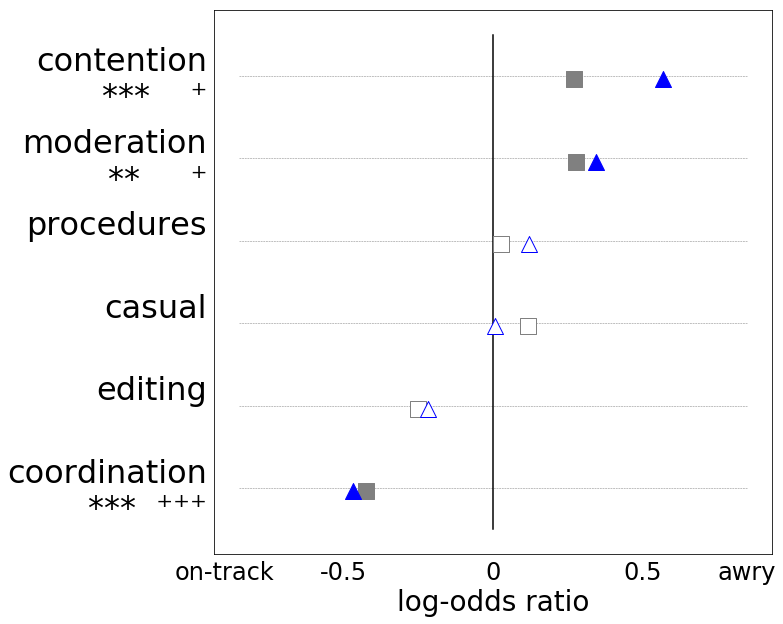

In [36]:
f, ax = plt.subplots(1,1, figsize=(10,10))
_ = draw_figure(ax, first_comparisons, second_comparisons, '')

## 4. Pipeline usage

We can also apply the framework via a pipeline that handles the following:
* processes text (via a pipeline supplied by the user; see cell below)
* transforms text to input representation (via `ColNormedTfidfTransformer`)
* derives framework output (via `ExpectedContextModelTransformer`)

In [37]:
from convokit.expected_context_framework import ExpectedContextModelPipeline

We initialize the pipeline with the following arguments:
* `text_field` specifies which utterance metadata field to use as text input.
* `share_tfidf_models` indicates whether we want to train one `ColNormedTfidfTransformer` model for both utterances and context-utterances. In this case, since we want different input representations for first and second comments, we set this argument to `False`.
* `text_pipe` specifies the pipeline used to compute the contents of `text_field`
* `tfidf_params` specifies the parameters to be passed into the underlying `ColNormedTfidfTransformer` object
* `min_terms` specifies the minimum number of terms in the vocabulary that an utterance must contain for it to be considered in fitting and transforming the underlying `ExpectedContextModelTransformer` object (see the `selector` argument passed into `ec_fw.fit` above)

All other arguments are inherited from `ExpectedContextModelTransformer`.

In [38]:
fw_pipe = ExpectedContextModelPipeline(context_field='next_id', output_prefix='fw',
        text_field='arcs', share_tfidf_models=False,
        text_pipe=wiki_arc_pipeline(), 
        tfidf_params={'binary': True, 'min_df': 50}, 
        min_terms=1,
        n_svd_dims=25, n_clusters=6, cluster_on='terms',
        random_state=1000, cluster_random_state=1000)

In [39]:
fw_pipe.fit(wiki_corpus,
            selector=lambda x: x.meta.get('next_id',None) is not None,
            context_selector=lambda x: x.reply_to is not None)

This should produce the same output as calling the constituent steps separately.

In [40]:
fw_pipe.ec_model.print_clusters()

CLUSTER 0 0
---
terms
           cluster_dist
index                  
'm_*           0.497348
thought_*      0.498929
guess_*        0.508338
sorry>*        0.521577
know_*         0.526687
had_*          0.531728
got_*          0.537593
's_*           0.543810
have>*         0.544413
saw_*          0.549280

context terms
          cluster_dist
index                 
saw_*         0.598228
yes>*         0.603147
knew_*        0.607990
but>*         0.614208
oh>*          0.615937
anyway>*      0.619059
hey>*         0.620055
guess_*       0.620307
oh_*          0.635252
and>*         0.639936

CLUSTER 1 1
---
terms
              cluster_dist
index                     
let_*             0.507374
done_*            0.509473
appreciate_*      0.512464
tried_*           0.524234
help_*            0.530647
let_know          0.536958
look_*            0.540756
hi>*              0.545773
hi_*              0.548464
take_*            0.549002

context terms
               cluster_dist
index    

In [41]:
fw_pipe.set_cluster_names(['casual', 'coordination', 
              'procedures', 'contention',
             'editing', 'moderation'])

The pipeline enables us to transform ad-hoc string input.

In [42]:
new_ut = fw_pipe.transform_utterance('Let me help you out with that')

In [43]:
print('type:', new_ut.meta['fw_clustering.cluster'])

type: coordination


Here, instead of storing vector representations with a corpus, the pipeline writes these representations to a field in the utterance metadata itself (since the utterance is not attached to a corpus):

In [44]:
# note that different versions of SpaCy may produce different outputs, since the
# dependency parses may change from version to version
new_ut.meta['fw_repr']

[-0.34251719530565966,
 0.02658927446810624,
 -0.01927147734336277,
 0.032577912301350556,
 -0.22583186273707992,
 0.3726452662095833,
 0.19622014569623866,
 -0.10407111691341157,
 -0.29038262872096327,
 -0.014681640364270429,
 0.16817088225571575,
 0.13965716231892997,
 -0.19330007418977502,
 0.335512083137985,
 -0.04301223983724843,
 -0.10041294183984298,
 0.3141634142240819,
 0.004730871157014037,
 -0.4032757831822109,
 -0.14092188454058427,
 -0.1225539502059763,
 0.009954456070505423,
 0.06985947800825029,
 -0.21434796397126002]